# Purpose

This notebook works through an example workflow of tracking Keras experiments using [MLFlow](https://www.mlflow.org).  

# Data

The CA housing data will be used for this example, which is a simple regressiont task. It will be loaded from the `sklearn` data loader.  I'll split off 20% into a test set and an additional 20% into a validation set.  Finally, I'll standardize the data using `StandardScaler` ahead of modeling.

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, test_size=0.2
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.2
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

pd.DataFrame(X_train, columns=housing.feature_names).describe()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,1.320900e+04,1.320900e+04,1.320900e+04,1.320900e+04,1.320900e+04,1.320900e+04,1.320900e+04,1.320900e+04
mean,-1.121893e-14,7.799886e-18,-2.641203e-16,-4.537584e-15,-3.173747e-17,2.305001e-16,5.637758e-14,1.225486e-13
std,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00
min,-1.787214e+00,-2.191399e+00,-1.997402e+00,-1.654438e+00,-1.245489e+00,-1.682332e-01,-1.440658e+00,-2.385516e+00
25%,-6.936570e-01,-8.413413e-01,-4.235239e-01,-1.895972e-01,-5.604738e-01,-5.445260e-02,-7.955274e-01,-1.113087e+00
50%,-1.782472e-01,3.222539e-02,-8.384526e-02,-9.872842e-02,-2.306519e-01,-2.426249e-02,-6.459320e-01,5.385741e-01
75%,4.689426e-01,6.675466e-01,2.775327e-01,1.264791e-02,2.583943e-01,1.225280e-02,9.762437e-01,7.830799e-01
max,5.896085e+00,1.858774e+00,5.562608e+01,7.177380e+01,2.996599e+01,9.678544e+01,2.939684e+00,2.624358e+00


# Model

The model used for this example will be a wide and deep network with the following characteristics:
- a deep path with `n_hidden` hidden layers with `n_neurons` at each layer
- a wide path connecting all inputs to the output
- all layers are fully connected
- two outpus:
    - one from the deep path alone, fit to the target
    - one from the concatenaded wide and deep paths, fit to the target

This type of multi-output architecture is usually used as a regularization technique, but I'm simply employing it here so my example has more than one loss to simultaneously minimize.  This model is very similar to the regression example I used in my [intro to Keras](https://github.com/mcnewcp/book-geron-ml-sklearn-keras-tensorflow/blob/main/10-intro-ann-keras/10-intro-ann-keras.ipynb) notebook and from Chapter 10 of [Hands on ML](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), so I won't explain the Keras code below.

The model build code should be functionalized so that the hyperparameters are generalized in the build and compile steps for integration into hyperparameter tuning.  I'm pulling out the following hyperparameters for tuning:
- `n_hidden`: number of hidden layers
- `n_neurons`: number of neurons per layer
- `activation`: activation funciton used in hidden layers

*Note*: I'm not tuning learning rate here.  In general I think it's best practice to choose a sufficiently low learning rate, high number of epochs, and use early stopping.  The goal of this stage of hyperparameter tuning is to simply identify promising model candidates.  Once promising candidates have been identified, the learning rate will be fine tuned.


In [2]:
import tensorflow as tf
from tensorflow import keras
print('tf version:', tf.__version__, ", keras version:", keras.__version__)

2023-02-13 15:44:23.159630: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


tf version: 2.10.0 , keras version: 2.10.0


In [26]:
def build_model(n_hidden=1, n_neurons=20, activation="relu"):
    inp = keras.layers.Input(shape=[8], name="input")  # input layer
    for layer in range(n_hidden):  # sequentially add hidden layers
        if layer == 0:
            hl = keras.layers.Dense(n_neurons, activation=activation)(inp)
        else:
            hl = keras.layers.Dense(n_neurons, activation=activation)(hl)
    concat = keras.layers.Concatenate()([hl, inp])  # concat deep and wide paths
    main_output = keras.layers.Dense(1, name="main_output")(concat)  # combined output
    aux_output = keras.layers.Dense(1, name="aux_output")(hl)  # deep output
    model = keras.Model(inputs=[inp], outputs=[main_output, aux_output])
    model.compile(
        loss=["mse", "mse"],
        loss_weights=[0.9, 0.1],  # weighting heavily towards main output
        optimizer=keras.optimizers.SGD(learning_rate=5e-3),
    )
    return model


In [31]:
model = build_model(n_hidden=2)

history = model.fit(
    X_train,
    [y_train, y_train],
    epochs=250,
    validation_data=(X_valid, [y_valid, y_valid]),
    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=0,
)


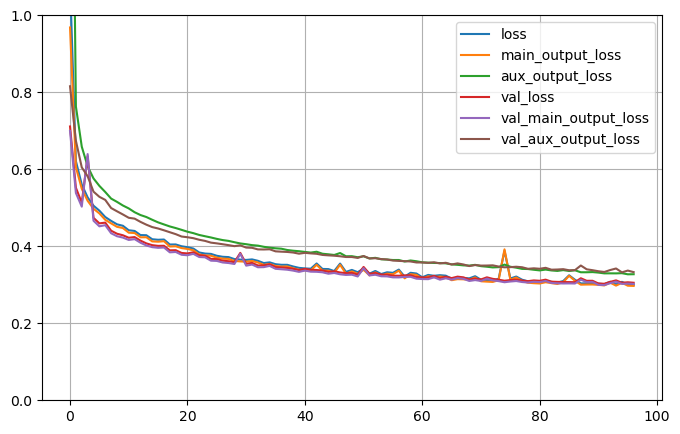

129/129 [==============================] - 0s 1ms/step - loss: 0.3237 - main_output_loss: 0.3209 - aux_output_loss: 0.3487

Total MSE: 0.3237
Main Loss: 0.3209
Aux Loss : 0.3487



In [32]:
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

total_loss, main_loss, aux_loss = model.evaluate([X_test], [y_test, y_test])
print(
    f"""
Total MSE: {round(total_loss, 4)}
Main Loss: {round(main_loss, 4)}
Aux Loss : {round(aux_loss, 4)}
"""
)
